In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.manifold import TSNE

In [2]:
plt.style.use('ggplot')

In [3]:
data=pd.read_csv('combined_data_with_loc.csv')
data.head()

,Community Name,Region,Map reference,Grid reference,Location,Population Density,Travel time to GPO (minutes),Distance to GPO (km),LGA,Primary Care Partnership,...,Travel time to nearest public hospital with emergency department,Distance to nearest public hospital with emergency department,Presentations to emergency departments due to injury,"Presentations to emergency departments due to injury, %",Category 4 & 5 emergency department presentations,"Category 4 & 5 emergency department presentations, %",geo_lat,geo_lon,cart_x,cart_y
0,Ascot Vale,Northern and Western Metropolitan,4,B3,6km NW of Melbourne,3758.623596,9.360142,6.958742,Moonee Valley (C),Inner North West Primary Care Partnership,...,6.630953,4.993841,679.257076,20.502456,1864.918123,56.290032,-37.775606,144.914871,-4.230377,4.251470
1,Braybrook,Northern and Western Metropolitan,4,A3,10km WNW of Melbourne,2025.468296,15.131666,11.595888,Maribyrnong (C),"HealthWest (b): Hobson's Bay, Maribyrnong, Wyn...",...,12.824977,10.161988,543.631989,20.647263,1683.966712,63.957428,-37.779315,144.858155,-9.212552,3.839001
2,Craigieburn,Northern and Western Metropolitan,2,A3,27km N of Melbourne,1034.970870,31.994666,43.100287,Hume (C),Hume-Whittlesea Primary Care Partnership,...,11.570855,15.213189,2044.424399,20.618005,5102.134434,51.454988,-37.570576,144.963028,0.000000,27.049690
3,Croydon,Eastern Metropolitan,2,B4,28km E of Melbourne,1730.064830,28.992647,34.071323,Maroondah (C),Outer East Primary Care Partnership,...,5.093285,3.601752,1754.954941,28.537825,3062.182462,49.795026,-37.813411,145.281013,27.933349,0.047723
4,Fawkner,Northern and Western Metropolitan,4,C1,12km N of Melbourne,2619.120089,17.405267,13.047142,Moreland (C),Inner North West Primary Care Partnership,...,11.510757,12.004044,680.401318,17.909865,1942.874353,51.141315,-37.705724,144.963028,0.000000,12.021947


In [4]:
#load feature category mapping
feature_category_dict=json.load(open('feature_category_dict.json'))
feature_category_dict

{'2007 population': ['2007 ERP age 0-4, persons',
  '2007 ERP age 0-4, %',
  '2007 ERP age 5-9, persons',
  '2007 ERP age 5-9, %',
  '2007 ERP age 10-14, persons',
  '2007 ERP age 10-14, %',
  '2007 ERP age 15-19, persons',
  '2007 ERP age 15-19, %',
  '2007 ERP age 20-24, persons',
  '2007 ERP age 20-24, %',
  '2007 ERP age 25-44, persons',
  '2007 ERP age 25-44, %',
  '2007 ERP age 45-64, persons',
  '2007 ERP age 45-64, %',
  '2007 ERP age 65-69, persons',
  '2007 ERP age 65-69, %',
  '2007 ERP age 70-74, persons',
  '2007 ERP age 70-74, %',
  '2007 ERP age 75-79, persons',
  '2007 ERP age 75-79, %',
  '2007 ERP age 80-84, persons',
  '2007 ERP age 80-84, %',
  '2007 ERP age 85+, persons',
  '2007 ERP age 85+, %',
  '2007 ERP, total'],
 '2007-2012 population change': ['% change, 2007-2012, age 0-4',
  '% change, 2007-2012, age 5-9',
  '% change, 2007-2012, age 10-14',
  '% change, 2007-2012, age 15-19',
  '% change, 2007-2012, age 20-24',
  '% change, 2007-2012, age 25-44',
  '% cha

# Perspective 1: Services Provided

In [5]:
# load the category 'Services'
category='Services'
features=feature_category_dict[category]
features

['Public Hospitals',
 'Private Hospitals',
 'Community Health Centres',
 'Bush Nursing Centres',
 'Allied Health',
 'Alternative Health',
 'Child Protection and Family',
 'Dental',
 'Disability',
 'General Practice',
 'Homelessness',
 'Mental Health',
 'Pharmacies',
 'Aged Care (High Care)',
 'Aged Care (Low Care)',
 'Aged Care (SRS)',
 'Kinder and/or Childcare',
 'Primary Schools',
 'Secondary Schools',
 'P12 Schools',
 'Other Schools',
 'Centrelink Offices',
 'Medicare Offices',
 'Medicare Access Points']

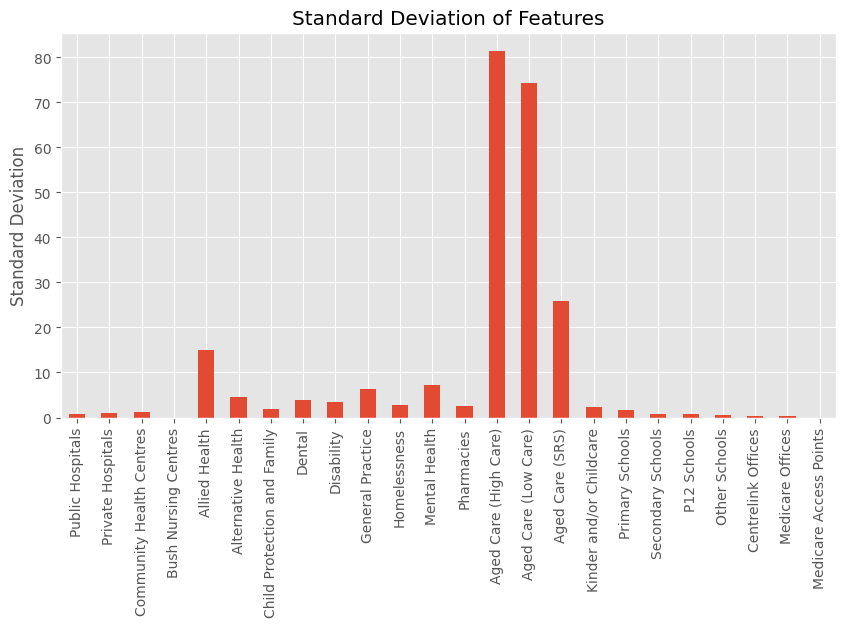

,Public Hospitals,Private Hospitals,Community Health Centres,Bush Nursing Centres,Allied Health,Alternative Health,Child Protection and Family,Dental,Disability,General Practice,...,Aged Care (Low Care),Aged Care (SRS),Kinder and/or Childcare,Primary Schools,Secondary Schools,P12 Schools,Other Schools,Centrelink Offices,Medicare Offices,Medicare Access Points
0,0,1,1,0,10,5,0,0,0,2,...,31,0,4,3,0,0,1,0,0,0
1,0,0,1,0,13,1,0,1,1,4,...,0,0,1,2,2,0,1,0,0,0
2,1,0,1,0,15,0,0,1,1,8,...,0,0,2,6,1,1,0,0,0,0
3,0,1,0,0,30,8,0,7,9,9,...,179,45,10,5,2,0,0,0,0,0
4,0,0,1,0,13,1,0,1,0,5,...,150,0,3,4,1,1,0,0,0,0


In [6]:
# extract the data for the category 'Services'
data_services=data[features]
# plot the standard deviation of the features
plt.figure(figsize=(10,5))
data_services.std().plot(kind='bar')
plt.title('Standard Deviation of Features')
plt.ylabel('Standard Deviation')
plt.show()
data_services.head()

In [7]:
# scale the data between 0 and 1
scaler=MinMaxScaler()
data_services_scaled=scaler.fit_transform(data_services)
data_services_scaled=pd.DataFrame(data_services_scaled,columns=features)
data_services_scaled.head()

,Public Hospitals,Private Hospitals,Community Health Centres,Bush Nursing Centres,Allied Health,Alternative Health,Child Protection and Family,Dental,Disability,General Practice,...,Aged Care (Low Care),Aged Care (SRS),Kinder and/or Childcare,Primary Schools,Secondary Schools,P12 Schools,Other Schools,Centrelink Offices,Medicare Offices,Medicare Access Points
0,0.00,0.25,0.166667,0.0,0.117647,0.3125,0.0,0.000000,0.000000,0.074074,...,0.110714,0.000000,0.4,0.500000,0.000000,0.000000,0.5,0.0,0.0,0.0
1,0.00,0.00,0.166667,0.0,0.152941,0.0625,0.0,0.066667,0.076923,0.148148,...,0.000000,0.000000,0.1,0.333333,0.666667,0.000000,0.5,0.0,0.0,0.0
2,0.25,0.00,0.166667,0.0,0.176471,0.0000,0.0,0.066667,0.076923,0.296296,...,0.000000,0.000000,0.2,1.000000,0.333333,0.333333,0.0,0.0,0.0,0.0
3,0.00,0.25,0.000000,0.0,0.352941,0.5000,0.0,0.466667,0.692308,0.333333,...,0.639286,0.381356,1.0,0.833333,0.666667,0.000000,0.0,0.0,0.0,0.0
4,0.00,0.00,0.166667,0.0,0.152941,0.0625,0.0,0.066667,0.000000,0.185185,...,0.535714,0.000000,0.3,0.666667,0.333333,0.333333,0.0,0.0,0.0,0.0


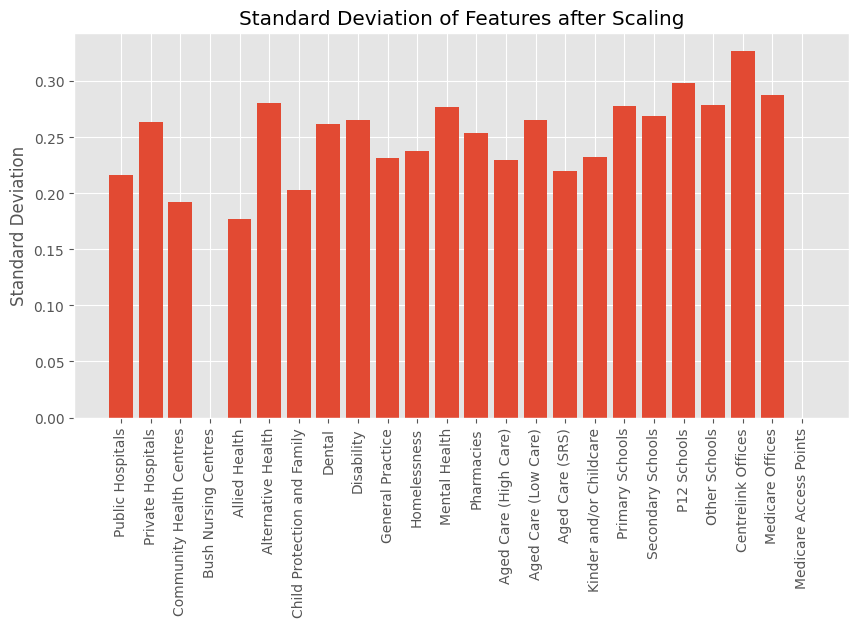

,Public Hospitals,Private Hospitals,Community Health Centres,Bush Nursing Centres,Allied Health,Alternative Health,Child Protection and Family,Dental,Disability,General Practice,...,Aged Care (Low Care),Aged Care (SRS),Kinder and/or Childcare,Primary Schools,Secondary Schools,P12 Schools,Other Schools,Centrelink Offices,Medicare Offices,Medicare Access Points
count,34.000000,34.000000,34.000000,34.0,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,...,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.0
mean,0.066176,0.183824,0.102941,0.0,0.160208,0.237132,0.068627,0.239216,0.233032,0.232026,...,0.248739,0.110419,0.261765,0.387255,0.225490,0.186275,0.205882,0.117647,0.088235,0.0
std,0.215927,0.263347,0.192514,0.0,0.176910,0.280683,0.202887,0.261628,0.265448,0.231442,...,0.265606,0.219691,0.232268,0.277436,0.268687,0.298043,0.278460,0.327035,0.287902,0.0
min,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,0.000000,0.000000,0.000000,0.0,0.064706,0.000000,0.000000,0.016667,0.019231,0.074074,...,0.000000,0.000000,0.100000,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
50%,0.000000,0.000000,0.000000,0.0,0.141176,0.125000,0.000000,0.133333,0.153846,0.185185,...,0.169643,0.000000,0.200000,0.333333,0.166667,0.000000,0.000000,0.000000,0.000000,0.0
75%,0.000000,0.250000,0.166667,0.0,0.197059,0.406250,0.000000,0.400000,0.307692,0.287037,...,0.418750,0.165254,0.400000,0.500000,0.333333,0.333333,0.500000,0.000000,0.000000,0.0
max,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0


In [8]:
# plot the standard deviation of the features
plt.figure(figsize=(10,5))
plt.bar(data_services_scaled.columns,data_services_scaled.std())
plt.xticks(rotation=90)
plt.ylabel('Standard Deviation')
plt.title('Standard Deviation of Features after Scaling')
plt.show()
data_services_scaled.describe()

In [9]:
data_services_scaled['suburb_services_score']=data_services_scaled.mean(axis=1)
data_services_scaled.head()

,Public Hospitals,Private Hospitals,Community Health Centres,Bush Nursing Centres,Allied Health,Alternative Health,Child Protection and Family,Dental,Disability,General Practice,...,Aged Care (SRS),Kinder and/or Childcare,Primary Schools,Secondary Schools,P12 Schools,Other Schools,Centrelink Offices,Medicare Offices,Medicare Access Points,suburb_services_score
0,0.00,0.25,0.166667,0.0,0.117647,0.3125,0.0,0.000000,0.000000,0.074074,...,0.000000,0.4,0.500000,0.000000,0.000000,0.5,0.0,0.0,0.0,0.124661
1,0.00,0.00,0.166667,0.0,0.152941,0.0625,0.0,0.066667,0.076923,0.148148,...,0.000000,0.1,0.333333,0.666667,0.000000,0.5,0.0,0.0,0.0,0.107885
2,0.25,0.00,0.166667,0.0,0.176471,0.0000,0.0,0.066667,0.076923,0.296296,...,0.000000,0.2,1.000000,0.333333,0.333333,0.0,0.0,0.0,0.0,0.133961
3,0.00,0.25,0.000000,0.0,0.352941,0.5000,0.0,0.466667,0.692308,0.333333,...,0.381356,1.0,0.833333,0.666667,0.000000,0.0,0.0,0.0,0.0,0.318122
4,0.00,0.00,0.166667,0.0,0.152941,0.0625,0.0,0.066667,0.000000,0.185185,...,0.000000,0.3,0.666667,0.333333,0.333333,0.0,0.0,0.0,0.0,0.139885


<Figure size 1000x500 with 0 Axes>

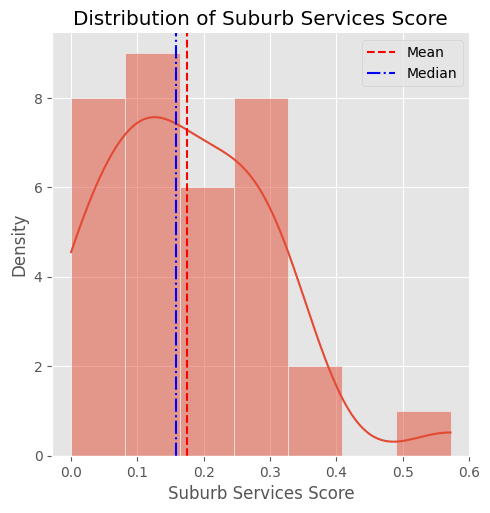

count    34.000000
mean      0.174807
std       0.127465
min       0.000000
25%       0.089691
50%       0.157910
75%       0.258785
max       0.572092
Name: suburb_services_score, dtype: float64

In [10]:
# plot the distribution of the suburb services score
plt.figure(figsize=(10,5))
sns.displot(data_services_scaled['suburb_services_score'],kde=True)
plt.title('Distribution of Suburb Services Score')
plt.xlabel('Suburb Services Score')
plt.ylabel('Density')
# show mean and median
plt.axvline(data_services_scaled['suburb_services_score'].mean(),color='red',label='Mean',linestyle='--')
plt.axvline(data_services_scaled['suburb_services_score'].median(),color='blue',label='Median',linestyle='-.')
plt.legend()
plt.show()
# describe the suburb services score
data_services_scaled['suburb_services_score'].describe()

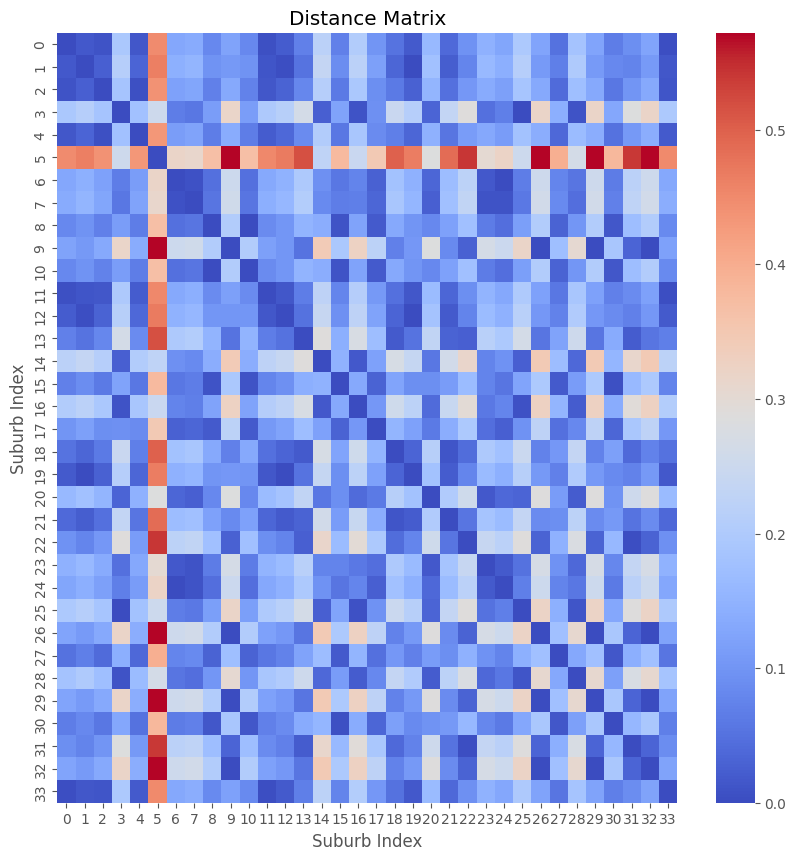

In [11]:
# define distance between two suburbs
# value is (absolute difference between the two suburb services scores)
def similarity_score(suburb1_idx,suburb2_idx):
	return np.abs(data_services_scaled['suburb_services_score'][suburb1_idx]-data_services_scaled['suburb_services_score'][suburb2_idx])

# calculate similarity matrix
distance_services=np.zeros((data_services_scaled.shape[0],data_services_scaled.shape[0]))
for i in range(data_services_scaled.shape[0]):
	for j in range(data_services_scaled.shape[0]):
		distance_services[i,j]=similarity_score(i,j)

# plot the similarity matrix
plt.figure(figsize=(10,10))
sns.heatmap(distance_services,cmap='coolwarm')
plt.title('Distance Matrix')
plt.xlabel('Suburb Index')
plt.ylabel('Suburb Index')
plt.show()

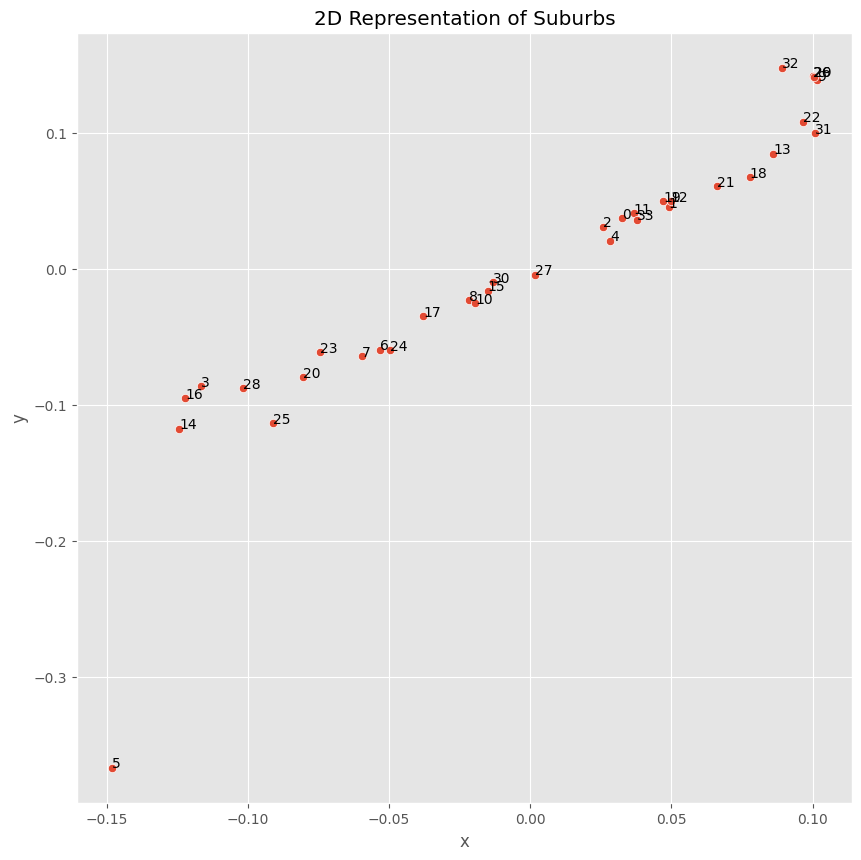

MDS Stress: 0.01049833971993749
0.999500118075889


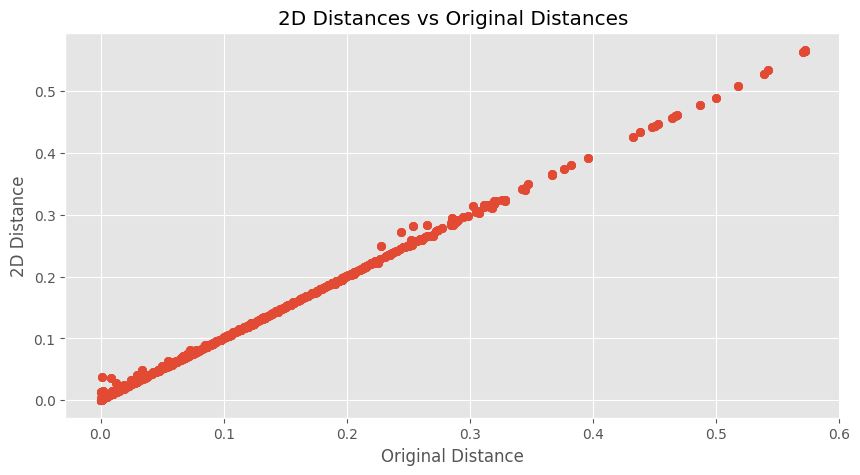

In [12]:
# do an MDS on the similarity matrix to get the 2D representation of the suburbs
mds=MDS(n_components=2,dissimilarity='precomputed',random_state=42)
suburb_2d=mds.fit_transform(distance_services)
suburb_2d=pd.DataFrame(suburb_2d,columns=['x','y'])

# plot the 2D representation of the suburbs
plt.figure(figsize=(10,10))
sns.scatterplot(x='x',y='y',data=suburb_2d)
plt.title('2D Representation of Suburbs')
plt.xlabel('x')
plt.ylabel('y')
# annotate the suburbs with the suburb index
for i in range(suburb_2d.shape[0]):
	plt.text(suburb_2d['x'].iloc[i],suburb_2d['y'].iloc[i],i)
plt.show()
suburb_2d.head()

print('MDS Stress:',mds.stress_)

# compute correlation between the pairwise distances in the 2D representation and the original distances
# compute pairwise distances in the 2D representation
distance_2d=np.zeros((suburb_2d.shape[0],suburb_2d.shape[0]))
for i in range(suburb_2d.shape[0]):
	for j in range(suburb_2d.shape[0]):
		distance_2d[i,j]=np.sqrt((suburb_2d['x'].iloc[i]-suburb_2d['x'].iloc[j])**2+(suburb_2d['y'].iloc[i]-suburb_2d['y'].iloc[j])**2)

# compute correlation between the pairwise distances in the 2D representation and the original distances
correlation=np.corrcoef(distance_services.flatten(),distance_2d.flatten())[0,1]
print(correlation)

# plot the 2D distances vs original distances
plt.figure(figsize=(10,5))
plt.scatter(distance_services.flatten(),distance_2d.flatten())
plt.xlabel('Original Distance')
plt.ylabel('2D Distance')
plt.title('2D Distances vs Original Distances')
plt.show()

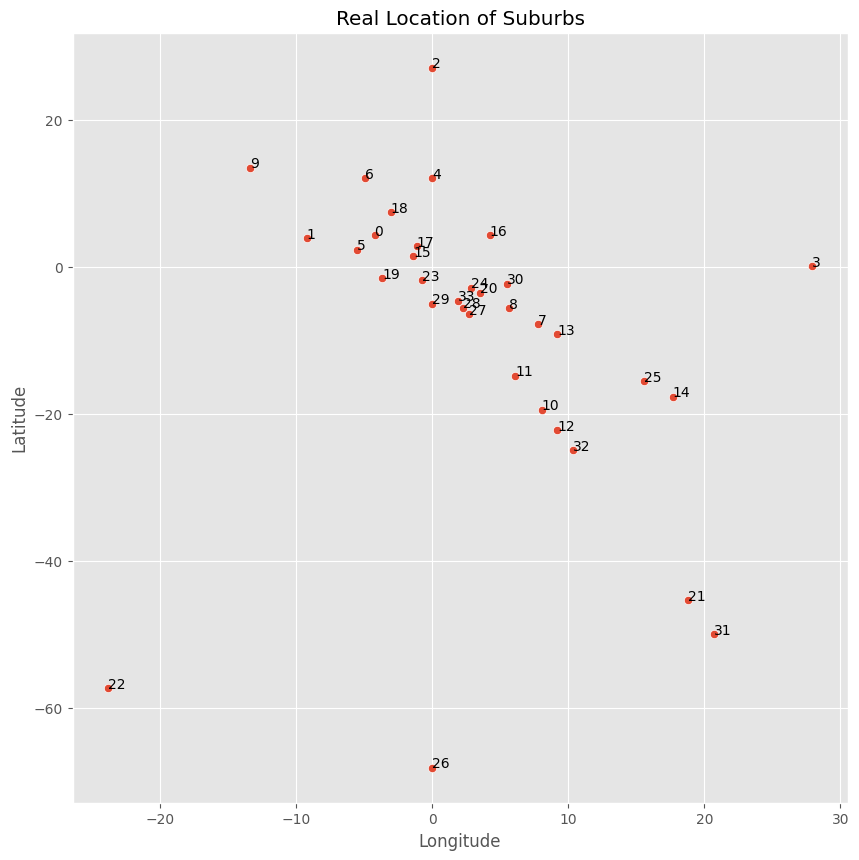

In [13]:
# do a similar plot for the real location of the suburbs
plt.figure(figsize=(10,10))
sns.scatterplot(x='cart_x',y='cart_y',data=data)
plt.title('Real Location of Suburbs')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
# annotate the suburbs with the suburb index
for i in range(data.shape[0]):
	plt.text(data['cart_x'].iloc[i],data['cart_y'].iloc[i],i)
plt.show()
# print the stress of the MDS



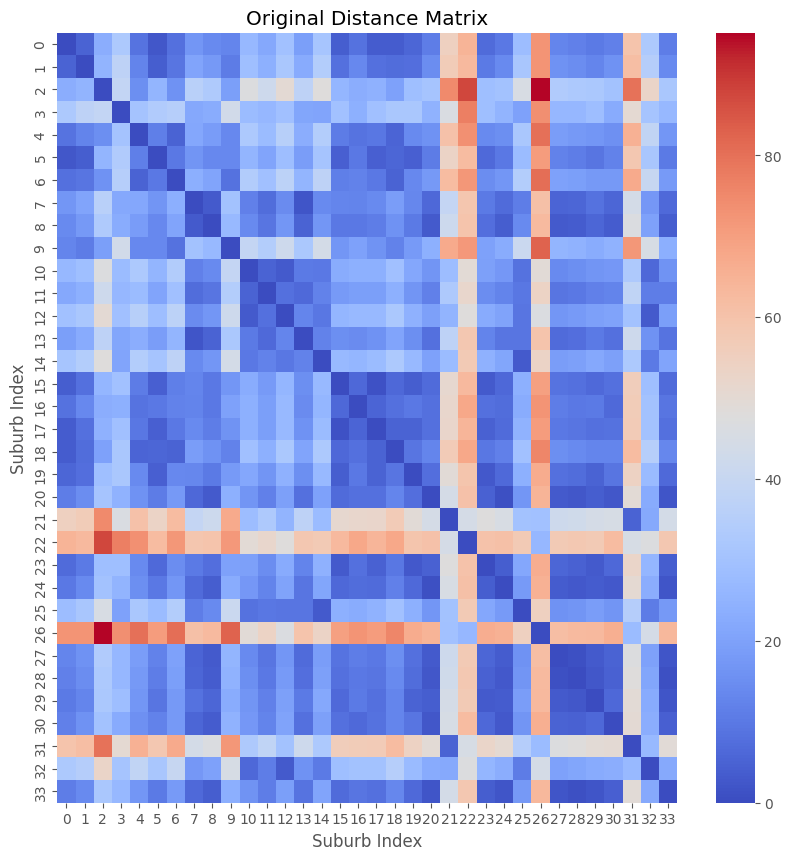

In [14]:
# pairwise distance between the original location
distance_original=np.zeros((data.shape[0],data.shape[0]))
for i in range(data.shape[0]):
	for j in range(data.shape[0]):
		distance_original[i,j]=np.sqrt((data['cart_x'].iloc[i]-data['cart_x'].iloc[j])**2+(data['cart_y'].iloc[i]-data['cart_y'].iloc[j])**2)

# plot the distance matrix
plt.figure(figsize=(10,10))
sns.heatmap(distance_original,cmap='coolwarm')
plt.title('Original Distance Matrix')
plt.xlabel('Suburb Index')
plt.ylabel('Suburb Index')
plt.show()

In [15]:
# compute the correlation matrix for the two 2D representations
from scipy.spatial import procrustes

# Example distance matrices
matrix1 = distance_services
matrix2 = distance_original

# Apply Procrustes analysis
mtx1, mtx2, disparity = procrustes(matrix1, matrix2)
print(f"Procrustes Disparity: {disparity}")


Procrustes Disparity: 0.8687077635866224


# Perspective 2: Land Use (percentage and amount)

In [16]:
feature='Land Use'
data_land=data[feature_category_dict[feature]]
data_land.head()

,Commercial (km^2),Commercial (%),Industrial (km^2),Industrial (%),Residential (km^2),Residential (%),Rural (km^2),Rural (%),Other (km^2),Other (%)
0,0.110250,2.874503,0.005093,0.132784,2.894001,75.454089,0.000000,0.000000,0.826102,21.538624
1,1.013147,23.425767,0.177854,4.112305,2.198204,50.826408,0.000000,0.000000,0.935720,21.635520
2,0.782388,2.215516,1.763098,4.992626,4.486082,12.703395,1.935031,5.479494,26.347439,74.608969
3,0.228507,1.609852,0.407614,2.871681,10.370552,73.061560,0.041521,0.292517,3.146073,22.164391
4,0.123132,2.421885,0.168014,3.304669,3.661186,72.011763,0.000000,0.000000,1.131817,22.261683


In [ ]:
# only keep the columns with '%' symbol
data_land_percentage=data_land.loc[:,data_land.columns.str.contains('%')]
data_land_percentage.head()

,Commercial (%),Industrial (%),Residential (%),Rural (%),Other (%)
0,2.874503,0.132784,75.454089,0.000000,21.538624
1,23.425767,4.112305,50.826408,0.000000,21.635520
2,2.215516,4.992626,12.703395,5.479494,74.608969
3,1.609852,2.871681,73.061560,0.292517,22.164391
4,2.421885,3.304669,72.011763,0.000000,22.261683


In [18]:
# convert percentage to float
data_land_frac=data_land_percentage/100
for col in data_land_frac.columns:
	data_land_frac[col]=data_land_frac[col].astype(float)
	# change the column name
	data_land_frac.rename(columns={col:col.replace('%','frac')},inplace=True)

# print the sum across all columns
print(data_land_frac.sum(axis=1))
data_land_frac.head()

0     1.0
1     1.0
2     1.0
3     1.0
4     1.0
5     1.0
6     1.0
7     1.0
8     1.0
9     1.0
10    1.0
11    1.0
12    1.0
13    1.0
14    1.0
15    1.0
16    1.0
17    1.0
18    1.0
19    1.0
20    1.0
21    1.0
22    1.0
23    1.0
24    1.0
25    1.0
26    1.0
27    1.0
28    1.0
29    1.0
30    1.0
31    1.0
32    1.0
33    1.0
dtype: float64


,Commercial (frac),Industrial (frac),Residential (frac),Rural (frac),Other (frac)
0,0.028745,0.001328,0.754541,0.000000,0.215386
1,0.234258,0.041123,0.508264,0.000000,0.216355
2,0.022155,0.049926,0.127034,0.054795,0.746090
3,0.016099,0.028717,0.730616,0.002925,0.221644
4,0.024219,0.033047,0.720118,0.000000,0.222617


In [19]:
import numpy as np
import pandas as pd

# # Example DataFrame for testing
# data_land_frac = pd.DataFrame({
#     'land_use1': [0.4, 0.6],
#     'land_use2': [0.3, 0.7],
#     'land_use3': [0.3, 0.2]
# })

# The dissimilarity function is Jensen-Shannon Divergence
def jensen_shannon_divergence(p, q):
    # Convert to np.array
    p, q = np.array(p), np.array(q)
    # Normalize p, q to probabilities
    p, q = p / p.sum(), q / q.sum()
    # Calculate the average of the two probability distributions
    m = (p + q) / 2
    # Add a small value to avoid log(0)
    p = np.where(p == 0, 1e-10, p)
    q = np.where(q == 0, 1e-10, q)
    m = np.where(m == 0, 1e-10, m)
    # Calculate the Jensen-Shannon Divergence
    return (0.5 * (np.sum(p * np.log(p / m)) + np.sum(q * np.log(q / m))))**0.5

# Calculate the Jensen-Shannon Divergence between two suburbs
def distance_JS(suburb1_idx, suburb2_idx):
    return jensen_shannon_divergence(
        data_land_frac.iloc[suburb1_idx], 
        data_land_frac.iloc[suburb2_idx]
    )

# Example usage
print(distance_JS(0, 1))

# import jensen_shannon_divergence
from scipy.spatial.distance import jensenshannon

# calculate the example distance
jensenshannon(data_land_frac.iloc[0],data_land_frac.iloc[1])

0.2638568515443729


np.float64(0.2638568515443729)

[[0.         0.26385685 0.48493482 ... 0.43653835 0.24044731 0.15774871]
 [0.26385685 0.         0.45684808 ... 0.47888127 0.3571305  0.16209332]
 [0.48493482 0.45684808 0.         ... 0.41567217 0.33056844 0.51184925]
 ...
 [0.43653835 0.47888127 0.41567217 ... 0.         0.4150792  0.47354306]
 [0.24044731 0.3571305  0.33056844 ... 0.4150792  0.         0.32385086]
 [0.15774871 0.16209332 0.51184925 ... 0.47354306 0.32385086 0.        ]]


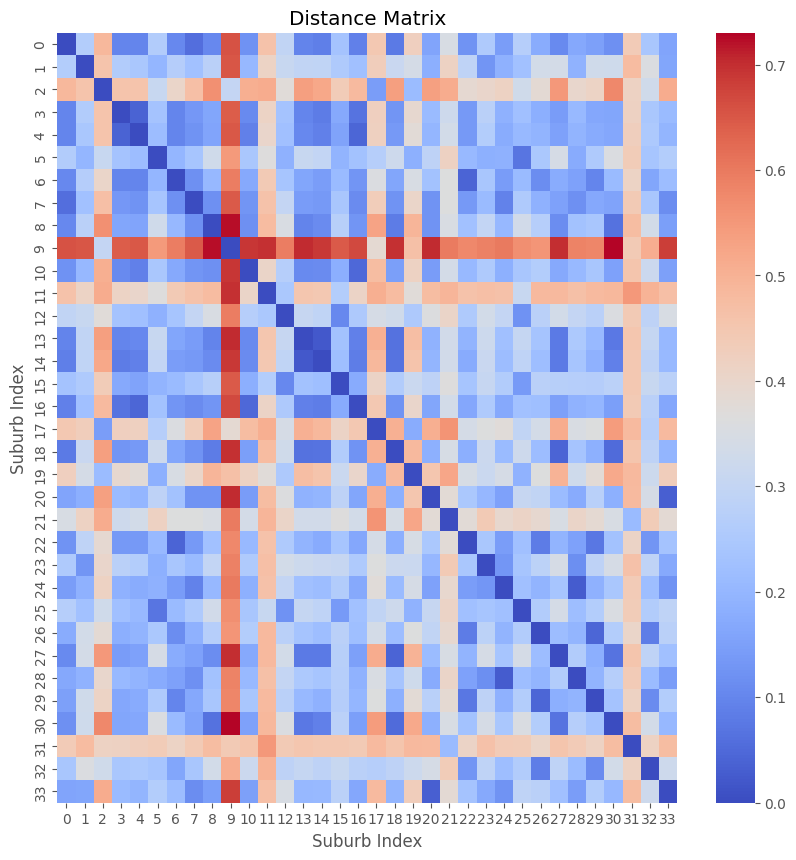

In [20]:
# compute the distance matrix in terms of Jensen-Shannon Divergence
distance_land_frac = np.zeros((data_land_frac.shape[0], data_land_frac.shape[0]))
for i in range(data_land_frac.shape[0]):
	for j in range(data_land_frac.shape[0]):
		distance_land_frac[i, j] = distance_JS(i, j)


print(distance_land_frac)
# plot the distance matrix
plt.figure(figsize=(10, 10))
sns.heatmap(distance_land_frac, cmap='coolwarm')
plt.title('Distance Matrix')
plt.xlabel('Suburb Index')
plt.ylabel('Suburb Index')
plt.show()

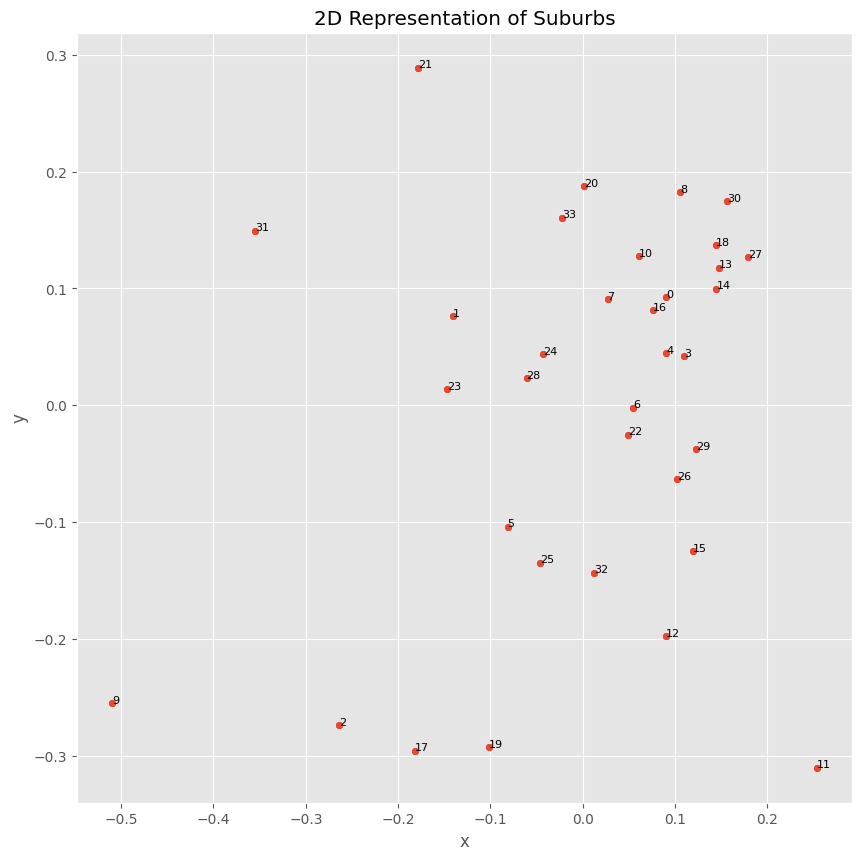

MDS Stress: 1.668711763178449
0.9548464646018643


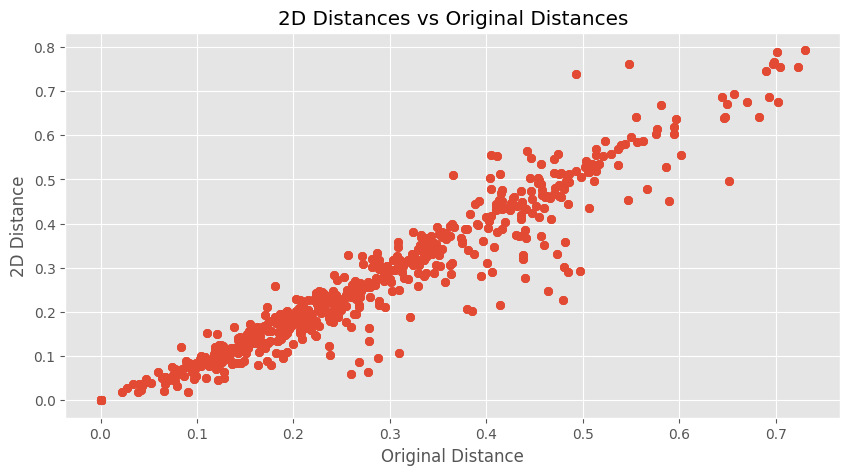

Procrustes Disparity: 0.09372234637173454


In [37]:
# do an MDS on the similarity matrix to get the 2D representation of the suburbs
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
suburb_2d = mds.fit_transform(distance_land_frac)

# plot the 2D representation of the suburbs
plt.figure(figsize=(10, 10))
sns.scatterplot(x=suburb_2d[:, 0], y=suburb_2d[:, 1])
plt.title('2D Representation of Suburbs')
plt.xlabel('x')
plt.ylabel('y')
# annotate the suburbs with the suburb index
for i in range(suburb_2d.shape[0]):
	plt.text(suburb_2d[i, 0], suburb_2d[i, 1], i, fontsize=8)
plt.show()

print('MDS Stress:', mds.stress_)

# compute correlation between the pairwise distances in the 2D representation and the original distances
# compute pairwise distances in the 2D representation
distance_2d = np.zeros((suburb_2d.shape[0], suburb_2d.shape[0]))
for i in range(suburb_2d.shape[0]):
	for j in range(suburb_2d.shape[0]):
		distance_2d[i, j] = np.sqrt((suburb_2d[i, 0] - suburb_2d[j, 0]) ** 2 + (suburb_2d[i, 1] - suburb_2d[j, 1]) ** 2)

# compute correlation between the pairwise distances in the 2D representation and the original distances
correlation = np.corrcoef(distance_land_frac.flatten(), distance_2d.flatten())[0, 1]
print(correlation)

# plot the 2D distances vs original distances
plt.figure(figsize=(10, 5))
plt.scatter(distance_land_frac.flatten(), distance_2d.flatten())
plt.xlabel('Original Distance')
plt.ylabel('2D Distance')
plt.title('2D Distances vs Original Distances')
plt.show()

# compute procrustes analysis for the original and 2D representation
from scipy.spatial import procrustes

# Apply Procrustes analysis
mtx1, mtx2, disparity = procrustes(distance_land_frac, distance_2d)
print(f"Procrustes Disparity: {disparity}")


In [22]:
# Apply Procrustes analysis
mtx1, mtx2, disparity = procrustes(distance_land_frac, distance_original)
print(f"Procrustes Disparity: {disparity}")


Procrustes Disparity: 0.8931504257498488


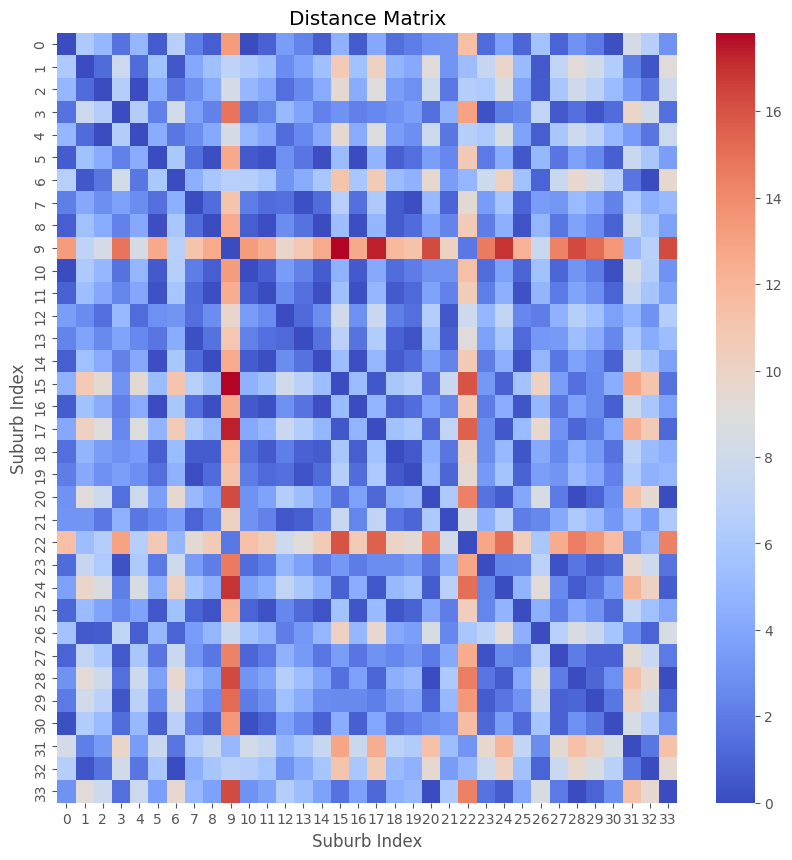

Procrustes Disparity: 0.7158501763582333


In [23]:
# trial with 'Population Density'
feature = 'Travel time to nearest public hospital with emergency department'
data_pop_density = data[feature]
data_pop_density.head()

# compute pairwise distance between the suburbs
distance_pop_density = np.zeros((data_pop_density.shape[0], data_pop_density.shape[0]))
for i in range(data_pop_density.shape[0]):
	for j in range(data_pop_density.shape[0]):
		distance_pop_density[i, j] = np.abs(data_pop_density.iloc[i] - data_pop_density.iloc[j])

# plot the distance matrix
plt.figure(figsize=(10, 10))
sns.heatmap(distance_pop_density, cmap='coolwarm')
plt.title('Distance Matrix')
plt.xlabel('Suburb Index')
plt.ylabel('Suburb Index')
plt.show()


# compute Procrustes analysis
mtx1, mtx2, disparity = procrustes(distance_pop_density, distance_original)
print(f"Procrustes Disparity: {disparity}")

In [24]:
# compute Procrustes analysis between JS and services
mtx1, mtx2, disparity = procrustes(distance_land_frac, distance_services)
print(f"Procrustes Disparity: {disparity}")


Procrustes Disparity: 0.8700801973283443


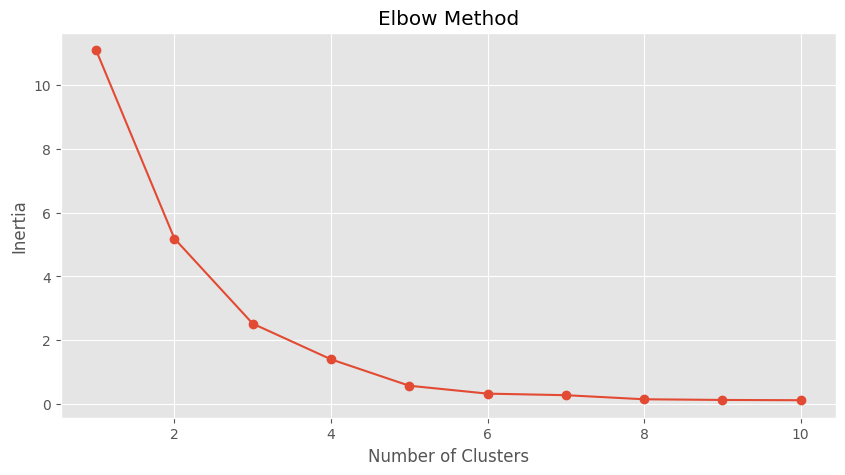

In [25]:
# cluster the JS distance projection on 2D and plot the clusters
from sklearn.cluster import KMeans

# run elbow method to find the optimal number of clusters
inertia = []
for i in range(1, 11):
	kmeans = KMeans(n_clusters=i, random_state=42)
	kmeans.fit(distance_services)
	inertia.append(kmeans.inertia_)
plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()





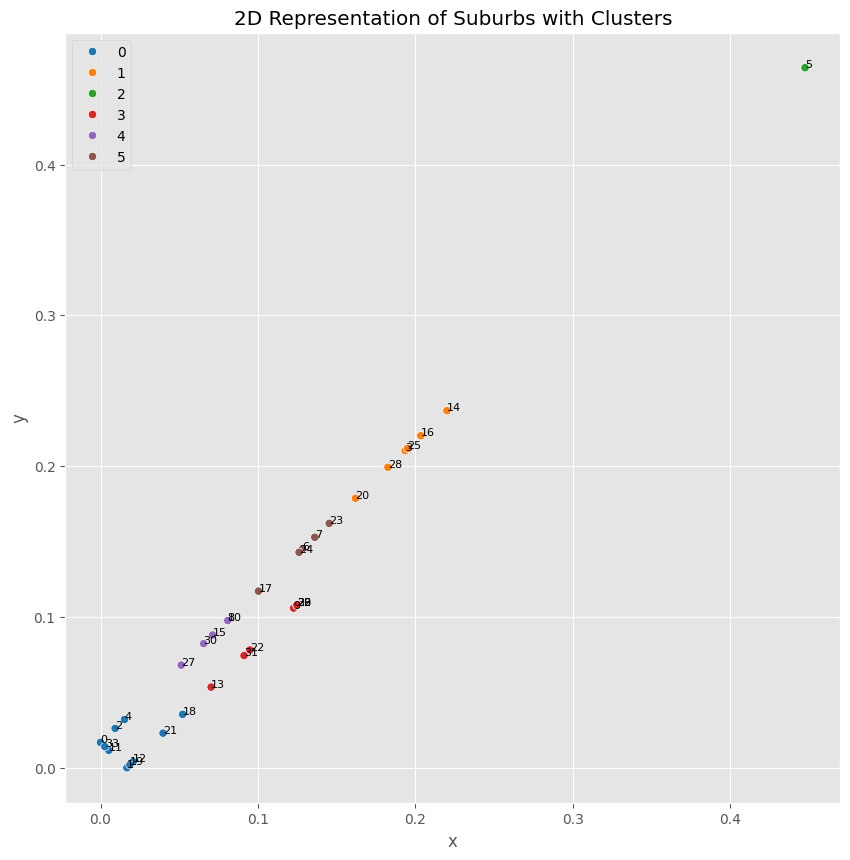

In [26]:
# run kmeans using 6 clusters
kmeans = KMeans(n_clusters=6, random_state=42)
kmeans.fit(distance_services)
services_cluster = kmeans.labels_

plt.figure(figsize=(10, 10))
sns.scatterplot(x=distance_services[:, 0], y=distance_services[:, 1], hue=services_cluster, palette='tab10')
plt.title('2D Representation of Suburbs with Clusters')
plt.xlabel('x')
plt.ylabel('y')
# annotate the suburbs with the suburb index
for i in range(distance_services.shape[0]):
	plt.text(distance_services[i, 0], distance_services[i, 1], i, fontsize=8)
plt.show()


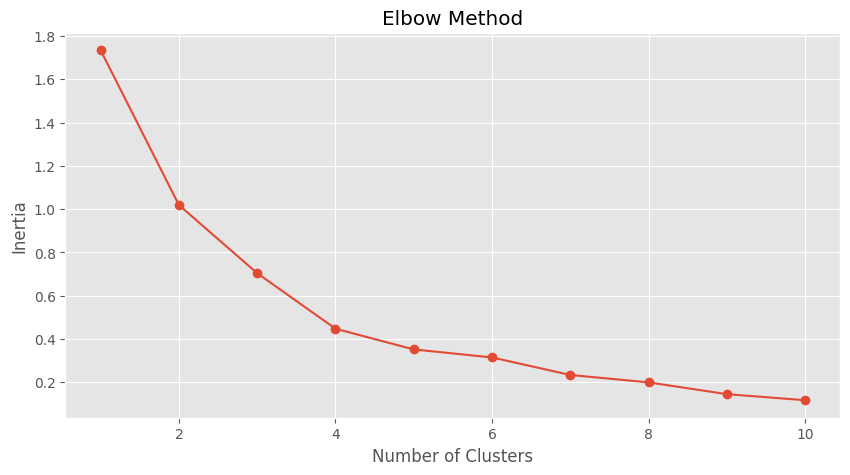

In [27]:
# cluster the JS distance projection on 2D and plot the clusters
from sklearn.cluster import KMeans

# run elbow method to find the optimal number of clusters
inertia = []
for i in range(1, 11):
	kmeans = KMeans(n_clusters=i, random_state=42)
	kmeans.fit(suburb_2d)
	inertia.append(kmeans.inertia_)
plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()





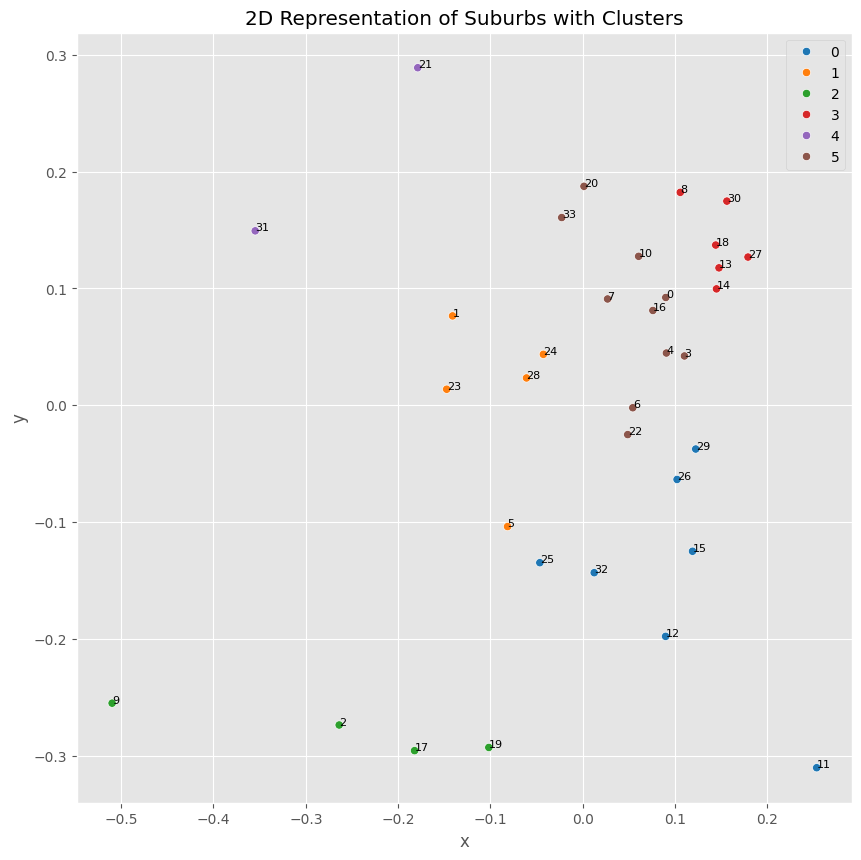

In [28]:
# run kmeans using 6 clusters
kmeans = KMeans(n_clusters=6, random_state=42)
kmeans.fit(suburb_2d)
js_distance_cluster = kmeans.labels_

plt.figure(figsize=(10, 10))
sns.scatterplot(x=suburb_2d[:, 0], y=suburb_2d[:, 1], hue=js_distance_cluster, palette='tab10')
plt.title('2D Representation of Suburbs with Clusters')
plt.xlabel('x')
plt.ylabel('y')
# annotate the suburbs with the suburb index
for i in range(suburb_2d.shape[0]):
	plt.text(suburb_2d[i, 0], suburb_2d[i, 1], i, fontsize=8)
plt.show()


[0 1 2 3 4 5] [2 5 4 0 3 1]


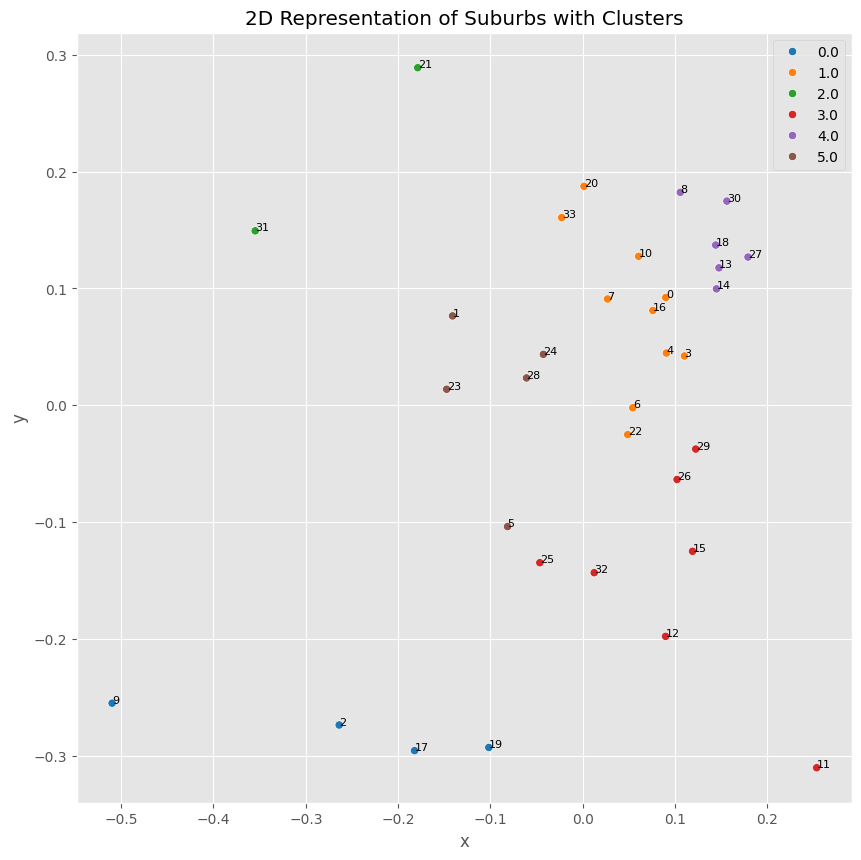

In [29]:
# compute the label-mapping between the two clustering results using Hungarian algorithm
from scipy.optimize import linear_sum_assignment

# compute the confusion matrix
confusion_matrix = np.zeros((6, 6))
for i in range(6):
	for j in range(6):
		confusion_matrix[i, j] = np.sum((services_cluster == i) & (js_distance_cluster == j))

# apply the Hungarian algorithm
row_ind, col_ind = linear_sum_assignment(-confusion_matrix)
print(row_ind, col_ind)
# map the labels
js_distance_cluster_mapped = np.zeros(js_distance_cluster.shape)

for i in range(6):
	js_distance_cluster_mapped[js_distance_cluster == col_ind[i]] = row_ind[i]

# remap the labels for the js_distance_cluster
js_distance_cluster = js_distance_cluster_mapped

# replot the 2D representation of the suburbs with the new clusters
plt.figure(figsize=(10, 10))
sns.scatterplot(x=suburb_2d[:, 0], y=suburb_2d[:, 1], hue=js_distance_cluster, palette='tab10')
plt.title('2D Representation of Suburbs with Clusters')
plt.xlabel('x')
plt.ylabel('y')
# annotate the suburbs with the suburb index
for i in range(suburb_2d.shape[0]):
	plt.text(suburb_2d[i, 0], suburb_2d[i, 1], i, fontsize=8)
plt.show()

In [30]:
# count the number of common suburbs in each cluster
# do for cluster 0, 1, 2, 3, 4, 5
matches_services_land = []
for i in range(6):
	print(f"Cluster {i}: {np.sum((services_cluster == i) & (js_distance_cluster_mapped == i))}")
	matches_services_land.append(np.sum((services_cluster == i) & (js_distance_cluster_mapped == i)))
							  
# count the match vs total number of suburbs
matches_services_land = np.array(matches_services_land)
total_suburbs = np.sum(matches_services_land)

print(f"Total Matches: {total_suburbs}")
print(f"Total Suburbs: {data.shape[0]}")
print(f"Accuracy: {total_suburbs / data.shape[0]}")
# print which points remain the same 
print(f"Matched Suburbs: \n{data['Community Name'][np.where(services_cluster == js_distance_cluster_mapped)[0]]}")



Cluster 0: 2
Cluster 1: 3
Cluster 2: 0
Cluster 3: 3
Cluster 4: 3
Cluster 5: 2
Total Matches: 13
Total Suburbs: 34
Accuracy: 0.38235294117647056
Matched Suburbs: 
2          Craigieburn
3              Croydon
8              Malvern
16           Northcote
19      Port Melbourne
20             Prahran
23     South Melbourne
24         South Yarra
26    St Andrews Beach
27       St Kilda East
29       St Kilda West
30              Toorak
32           Waterways
Name: Community Name, dtype: object


In [31]:
np.where(services_cluster == js_distance_cluster_mapped)[0]

array([ 2,  3,  8, 16, 19, 20, 23, 24, 26, 27, 29, 30, 32])

In [32]:
# find where na values are in data
data[feature_category_dict['2012 population']].isna().sum()


2012 ERP age 0-4, persons      0
2012 ERP age 0-4, %            0
2012 ERP age 5-9, persons      0
2012 ERP age 5-9, %            0
2012 ERP age 10-14, persons    0
2012 ERP age 10-14, %          0
2012 ERP age 15-19, persons    0
2012 ERP age 15-19, %          0
2012 ERP age 20-24, persons    0
2012 ERP age 20-24, %          0
2012 ERP age 25-44, persons    0
2012 ERP age 25-44, %          0
2012 ERP age 45-64, persons    0
2012 ERP age 45-64, %          0
2012 ERP age 65-69, persons    0
2012 ERP age 65-69, %          0
2012 ERP age 70-74, persons    0
2012 ERP age 70-74, %          0
2012 ERP age 75-79, persons    0
2012 ERP age 75-79, %          0
2012 ERP age 80-84, persons    0
2012 ERP age 80-84, %          0
2012 ERP age 85+, persons      0
2012 ERP age 85+, %            0
2012 ERP, total                0
dtype: int64

Correlation: 0.055337805747100094
P-value: 0.05998671411479324


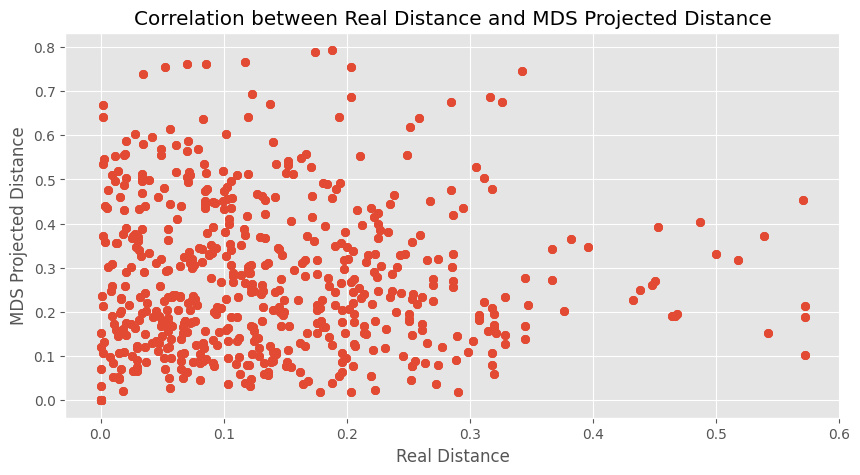

In [33]:
# compute the correlation between the MDS projected 2D representation and the real distance
from scipy.stats import pearsonr
from scipy.stats import spearmanr

# flatten the distance matrix
distance_services_flat = distance_services.flatten()

# flatten the MDS projected 2D representation after computing the pairwise distance
distance_services_2d = np.zeros((data_services_scaled.shape[0], data_services_scaled.shape[0]))
for i in range(data_services_scaled.shape[0]):
	for j in range(data_services_scaled.shape[0]):
		distance_services_2d[i, j] = np.linalg.norm(suburb_2d[i] - suburb_2d[j])

distance_services_2d_flat = distance_services_2d.flatten()

# compute the correlation
correlation, p_value = spearmanr(distance_services_flat, distance_services_2d_flat)
print(f"Correlation: {correlation}")
print(f"P-value: {p_value}")

# plot the correlation
plt.figure(figsize=(10, 5))
plt.scatter(distance_services_flat, distance_services_2d_flat)
plt.title('Correlation between Real Distance and MDS Projected Distance')
plt.xlabel('Real Distance')
plt.ylabel('MDS Projected Distance')
plt.show()


<Axes: >

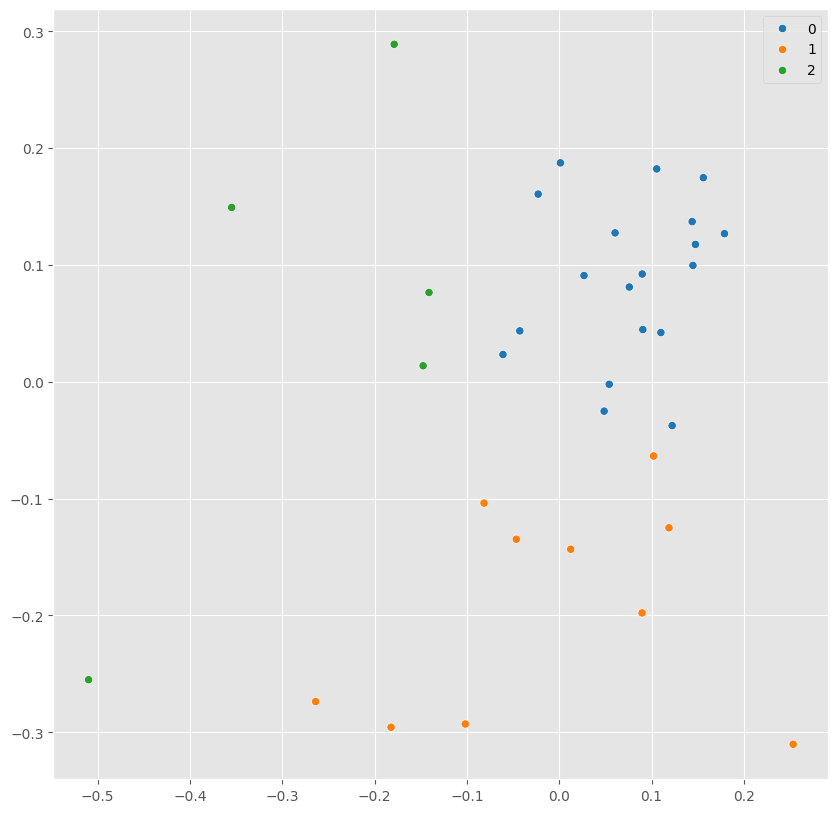

In [36]:
import numpy as np
from scipy.spatial.distance import jensenshannon
from sklearn.cluster import SpectralClustering

# # Step 1: Compute the JS distance matrix
# # Assume 'data' is an array of probability distributions of shape (n_samples, n_features)
# n_samples = len(data)
# js_distance_matrix = np.zeros((n_samples, n_samples))

# for i in range(n_samples):
#     for j in range(i + 1, n_samples):
#         # Compute JS distance between probability distributions
#         js_distance = jensenshannon(data[i], data[j])
#         js_distance_matrix[i, j] = js_distance
#         js_distance_matrix[j, i] = js_distance

# Step 2: Convert the JS distance matrix to a similarity matrix using a Gaussian kernel
sigma = 1.0  # Adjust sigma as needed
similarity_matrix = np.exp(-distance_2d ** 2 / (2.0 * sigma ** 2))

# Step 3: Apply spectral clustering
n_clusters = 3  # Specify the number of clusters
spectral_clustering = SpectralClustering(
    n_clusters=n_clusters,
    affinity='precomputed',  # Use the precomputed similarity matrix
    assign_labels='kmeans',  # You can choose 'kmeans' or 'discretize'
    random_state=42
)

# Fit and predict clusters
labels = spectral_clustering.fit_predict(similarity_matrix)

# 'labels' will contain the cluster labels for each data point

# plot the 2D representation of the suburbs
plt.figure(figsize=(10, 10))
sns.scatterplot(x=suburb_2d[:, 0], y=suburb_2d[:, 1], hue=labels, palette='tab10')

